<a href="https://colab.research.google.com/github/apoorvap11/RML--Group-6/blob/main/assign_2_Group_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## License

Copyright 2021 - 2023 Patrick Hall (jphall@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

*DISCLAIMER*: This notebook is not legal or compliance advice.

# Assignment 2  Group 6


#### Imports and inits

In [47]:
!pip install h2o
!pip install interpret
!pip install xgboost

In [48]:
import datetime                                               # for timestamp
import h2o                                                    # base h2o package for python
from h2o.estimators.glm import H2OGeneralizedLinearEstimator  # h2o elastic net models class
from h2o.grid.grid_search import H2OGridSearch                # grid search class and syntax for h2o models
from interpret import show                                    # basic visualizations from interpret package
from interpret.glassbox import ExplainableBoostingClassifier  # interpret ebm class
from interpret.perf import ROC                                # ROC measure for ebm
import itertools                                              # for cartesian product of parameters
import matplotlib.pyplot as plt                               # basic plotting
import numpy as np                                            # for basic array manipulation
import pandas as pd                                           # for dataframe manipulation
import seaborn as sns                                         # slightly better plotting
import time                                                   # for timers
import xgboost as xgb                                         # base xgboost package for python

# set numpy random seed for better reproducibility
SEED = 12345

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='6G', nthreads=NTHREAD) # start h2o with plenty of memory and threads
h2o.remove_all()                              # clears h2o memory
h2o.no_progress()                             # turn off h2o progress indicators

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 hours 44 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,3 days
H2O_cluster_name:,H2O_from_python_unknownUser_udkhfv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.457 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


#### Start global timer

In [49]:
tic = time.time()

## Mount shared drive

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Import data

In [51]:
data = pd.read_csv('/content/drive/My Drive/DNSC_6330_Software/data/hmda_train_preprocessed.csv')
test = pd.read_csv('/content/drive/My Drive/DNSC_6330_Software/data/hmda_test_preprocessed.csv')

#### Assign basic modeling roles

In [52]:
y_name = 'high_priced'
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']

## Fit interpretable models

#### Split data into train and validation partitions

In [53]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


#### Define wrapper function for grid search

In [54]:
def glm_grid(x_names, y_name, htrain, hvalid, seed):

    """ Wrapper function for penalized GLM with alpha and lambda search.

    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param htrain: Training H2OFrame.
    :param hvalid: Validation H2OFrame.
    :param seed: Random seed for better reproducibility.
    :return: Best H2OGeneralizedLinearEstimator.
    """

    alpha_opts = [0.01, 0.25, 0.5, 0.99]  # always keep some L2

    # define search criteria
    # i.e., over alpha
    # lamda search handled by lambda_search param below
    hyper_parameters = {'alpha': alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(family='binomial',
                                      lambda_search=True,
                                      seed=seed), # seed for grid search
        hyper_params=hyper_parameters)

    # execute training w/ grid search
    grid.train(y=y_name,
               x=x_names,
               training_frame=htrain,
               validation_frame=hvalid,
               seed=seed) # seed for training

    # select best model from grid search
    best_model = grid.get_grid()[0]
    del grid

    return best_model

#### Fit elastic net with grid search

In [55]:
# start local timer
glm_tic = time.time()

# convert data to h2o frames
htrain = h2o.H2OFrame(train)
hvalid = h2o.H2OFrame(valid)

# train with grid search
best_glm = glm_grid(x_names, y_name, htrain, hvalid, SEED)

# end local timer
glm_toc = time.time() - glm_tic
print('Elastic net GLM training completed in %.2f s.' % (glm_toc))

/usr/local/lib/python3.11/dist-packages/h2o/grid/grid_search.py:434: UserWarning: Adding alpha array to hyperparameter runs slower with gridsearch. This is due to the fact that the algo has to run initialization for every alpha value. Setting the alpha array as a model parameter will skip the initialization and run faster overall.
  warnings.warn(w_message)


Elastic net GLM training completed in 32.36 s.


#### Basic AUC assessment

In [56]:
print('Validation AUC: %.4f.' % best_glm.auc(valid=True))

Validation AUC: 0.7538.


#### Score validation data with model

In [57]:
best_glm_phat = best_glm.predict(hvalid).as_data_frame()
best_glm_phat.drop(['predict', 'p0'], axis=1, inplace=True)
best_glm_phat.columns = ['phat']
best_glm_phat = pd.concat([valid.reset_index(drop=True), best_glm_phat], axis=1)
best_glm_phat.head()

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.158336
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.159289
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.070368
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.124670
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.045170


#### Utility function for selecting percentiles

In [59]:
def get_percentile_dict(yhat_name, frame, id_):

    """ Returns the percentiles of a column, yhat_name, as the indices based on
        another column id_.
        :param yhat_name: Name of column in frame in which to find percentiles.
        :param frame: Pandas frame.
        :param id_: Validation Pandas frame containing yhat and id_.
        :return: Dictionary of percentile values and index column values.
    """

    # create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat_name, inplace=True)
    sort_df.reset_index(inplace=True)

    # find top and bottom percentiles
    percentiles_dict = {0: sort_df.loc[0, id_], 99: sort_df.loc[sort_df.shape[0] - 1, id_]}

    # find 10th-90th percentiles
    inc = sort_df.shape[0] // 10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc, id_]

    return percentiles_dict

#### Select percentiles from predictions

In [60]:
best_glm_percentiles = get_percentile_dict('phat', best_glm_phat, 'row_id')
for key in sorted(best_glm_percentiles.keys()):
    print(str(key) + ': ' + str(best_glm_percentiles[key]))

0: 152878
10: 116189
20: 51525
30: 8364
40: 2069
50: 110
60: 3896
70: 12767
80: 135486
90: 91124
99: 46601


#### Collect global feature importance info

In [61]:
# use coefficients as relative global feature importance
global_fi = pd.DataFrame.from_dict(best_glm.coef(), columns=['GLM Importance'], orient='index')
global_fi.drop('Intercept', inplace=True)
global_fi['GLM Importance'] = np.abs(global_fi['GLM Importance'])

#### Collect local feature importance info- refered to ChatGPT

*   List item
*   List item



In [62]:
import xgboost as xgb

# Convert to DMatrix using your Pandas DataFrames
dtrain = xgb.DMatrix(train[x_names], label=train[y_name])
dvalid = xgb.DMatrix(valid[x_names], label=valid[y_name])

# Best hyperparameters from Assignment 1
params = {
    'booster': 'gbtree',
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'seed': 12345,
    'colsample_bytree': 0.9,
    'colsample_bylevel': 0.9,
    'eta': 0.05,
    'max_depth': 3,
    'reg_alpha': 0.05,
    'reg_lambda': 0.05,
    'subsample': 0.7,
    'min_child_weight': 5,
    'gamma': 0.4,
    'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)
}

# Train directly without grid search
best_xgb_model = xgb.train(
    params,
    dtrain,
     num_boost_round=100,
    evals=[(dvalid, "eval")],
    early_stopping_rounds=10,
    verbose_eval=True
)


[0]	eval-auc:0.75940
[1]	eval-auc:0.76469
[2]	eval-auc:0.77073
[3]	eval-auc:0.77368
[4]	eval-auc:0.77353
[5]	eval-auc:0.77299
[6]	eval-auc:0.77452
[7]	eval-auc:0.77470
[8]	eval-auc:0.77511
[9]	eval-auc:0.77505
[10]	eval-auc:0.77661
[11]	eval-auc:0.77679
[12]	eval-auc:0.77673
[13]	eval-auc:0.77689
[14]	eval-auc:0.77777
[15]	eval-auc:0.77792
[16]	eval-auc:0.77811
[17]	eval-auc:0.77835
[18]	eval-auc:0.77887
[19]	eval-auc:0.77913
[20]	eval-auc:0.78069
[21]	eval-auc:0.78138
[22]	eval-auc:0.78178
[23]	eval-auc:0.78182
[24]	eval-auc:0.78208
[25]	eval-auc:0.78206
[26]	eval-auc:0.78208
[27]	eval-auc:0.78213
[28]	eval-auc:0.78222
[29]	eval-auc:0.78249
[30]	eval-auc:0.78261
[31]	eval-auc:0.78266
[32]	eval-auc:0.78282
[33]	eval-auc:0.78310
[34]	eval-auc:0.78313
[35]	eval-auc:0.78316
[36]	eval-auc:0.78323
[37]	eval-auc:0.78327
[38]	eval-auc:0.78355
[39]	eval-auc:0.78364
[40]	eval-auc:0.78386
[41]	eval-auc:0.78403
[42]	eval-auc:0.78421
[43]	eval-auc:0.78440
[44]	eval-auc:0.78473
[45]	eval-auc:0.7849

In [63]:
# use (coefficient * value) as local feature importance

# init frame to store local contribs
local_fi_dict = {10: pd.DataFrame(columns = ['GLM Contribution'], index=x_names),
                 50: pd.DataFrame(columns = ['GLM Contribution'], index=x_names),
                 90: pd.DataFrame(columns = ['GLM Contribution'], index=x_names)}

# get (coefficient * value) at three percentiles of phat
for name in x_names:
    for percentile in [10, 50, 90]:

        # local contributions = beta_j * x_i,j
        local_fi_dict[percentile].loc[name, 'GLM Contribution'] =\
            best_glm.coef()[name] *\
            valid[valid['row_id'] == int(best_glm_percentiles[percentile])][name].values[0]

#### Define utility function for random grid search

In [64]:
import xgboost as xgb

# Convert data to DMatrix using your Pandas DataFrames
dtrain = xgb.DMatrix(train[x_names], label=train[y_name])
dvalid = xgb.DMatrix(valid[x_names], label=valid[y_name])

# Best hyperparameters from Assignment 1
params = {
    'booster': 'gbtree',
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'seed': 12345,
    'colsample_bytree': 0.9,
    'colsample_bylevel': 0.9,
    'eta': 0.05,
    'max_depth': 3,
    'reg_alpha': 0.05,
    'reg_lambda': 0.05,
    'subsample': 0.7,
    'min_child_weight': 5,
    'gamma': 0.4,
    'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)
}

# Train the final model directly (no grid search)
best_mxgb = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=[(dvalid, "eval")],
    early_stopping_rounds=10,
    verbose_eval=True
)


[0]	eval-auc:0.75940
[1]	eval-auc:0.76469
[2]	eval-auc:0.77073
[3]	eval-auc:0.77368
[4]	eval-auc:0.77353
[5]	eval-auc:0.77299
[6]	eval-auc:0.77452
[7]	eval-auc:0.77470
[8]	eval-auc:0.77511
[9]	eval-auc:0.77505
[10]	eval-auc:0.77661
[11]	eval-auc:0.77679
[12]	eval-auc:0.77673
[13]	eval-auc:0.77689
[14]	eval-auc:0.77777
[15]	eval-auc:0.77792
[16]	eval-auc:0.77811
[17]	eval-auc:0.77835
[18]	eval-auc:0.77887
[19]	eval-auc:0.77913
[20]	eval-auc:0.78069
[21]	eval-auc:0.78138
[22]	eval-auc:0.78178
[23]	eval-auc:0.78182
[24]	eval-auc:0.78208
[25]	eval-auc:0.78206
[26]	eval-auc:0.78208
[27]	eval-auc:0.78213
[28]	eval-auc:0.78222
[29]	eval-auc:0.78249
[30]	eval-auc:0.78261
[31]	eval-auc:0.78266
[32]	eval-auc:0.78282
[33]	eval-auc:0.78310
[34]	eval-auc:0.78313
[35]	eval-auc:0.78316
[36]	eval-auc:0.78323
[37]	eval-auc:0.78327
[38]	eval-auc:0.78355
[39]	eval-auc:0.78364
[40]	eval-auc:0.78386
[41]	eval-auc:0.78403
[42]	eval-auc:0.78421
[43]	eval-auc:0.78440
[44]	eval-auc:0.78473
[45]	eval-auc:0.7849

#### Basic AUC assessment

In [65]:
print('Validation AUC: %.4f.' % best_mxgb.best_score)

Validation AUC: 0.7899.


#### Score validation data with model

In [66]:
best_mxgb_phat = pd.DataFrame(best_mxgb.predict(dvalid, iteration_range=(0, best_mxgb.best_iteration)), columns=['phat'])
best_mxgb_phat = pd.concat([valid.reset_index(drop=True), best_mxgb_phat], axis=1)
best_mxgb_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.244447
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.242291
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.039705
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.024308
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.012563


#### Select percentiles from predictions

In [67]:
best_mxgb_percentiles = get_percentile_dict('phat', best_mxgb_phat, 'row_id')
for key in sorted(best_mxgb_percentiles.keys()):
    print(str(key) + ': ' + str(best_mxgb_percentiles[key]))

0: 15728
10: 129755
20: 38319
30: 28527
40: 146071
50: 23357
60: 73156
70: 68600
80: 70532
90: 87839
99: 75300


#### Calculate Shapley values

In [68]:
shapley_contribs = best_mxgb.predict(dvalid, pred_contribs=True, iteration_range=(0, best_mxgb.best_iteration))

#### Collect global feature importance info

In [69]:
# use mean abs SHAP as feature importance
shapley_contribs_df = pd.DataFrame(shapley_contribs, columns=x_names + ['intercept'])
global_fi['MXGB Importance'] = np.abs(shapley_contribs_df.drop('intercept', axis=1)).mean()

#### Collect local feature importance info

In [70]:
# create mapping between validation row_id and Shapely array index values
valid_idx_map = valid['row_id'].copy(deep=True)
valid_idx_map.reset_index(drop=True, inplace=True)

# collect SHAP values at three percentiles of phat
for percentile in [10, 50, 90]:

    # using valid_idx_map and percentiles dict
    # to find the right local contributions
    idx = valid_idx_map[valid_idx_map == int(best_mxgb_percentiles[percentile])].index[0]
    s_df = pd.DataFrame(shapley_contribs[idx, :-1].T, columns=['MXGB Contribution'], index=x_names)
    local_fi_dict[percentile]['MXGB Contribution'] = 0
    local_fi_dict[percentile].update(s_df)

<ipython-input-70-71cfd201e782>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.58723500e-02  1.48415146e-03  0.00000000e+00 -1.01326421e-01
 -1.21932209e+00  8.12464350e-06  5.42597380e-03 -3.65528703e-01
 -5.35753462e-03 -4.05540407e-01]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  local_fi_dict[percentile].update(s_df)
<ipython-input-70-71cfd201e782>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 7.36980466e-03  2.06879209e-04  0.00000000e+00  2.76127215e-02
 -1.50904581e-01  1.31689530e-05  5.40000433e-03 -1.08828777e-02
  3.50182294e-03 -2.97534466e-01]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  local_fi_dict[percentile].update(s_df)
<ipython-input-70-71cfd201e782>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and

#### Fit EBM with random grid search

In [71]:
from interpret.glassbox import ExplainableBoostingClassifier

best_ebm = ExplainableBoostingClassifier(
    max_bins=512,
    max_interaction_bins=64,
    interactions=15,
    outer_bags=4,
    inner_bags=0,
    learning_rate=0.05,
    validation_size=0.1,
    min_samples_leaf=10,
    max_leaves=3,
    early_stopping_rounds=100,
    random_state=12345
)

best_ebm.fit(train[x_names], train[y_name])
print("EBM training completed.")


EBM training completed.


#### Basic AUC assessment

In [73]:
best_ebm_perf = ROC(best_ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
print('Validation AUC: %.4f.' % best_ebm_perf._internal_obj['overall']['auc'])

Validation AUC: 0.8250.


#### Score validation data with model

In [74]:
best_ebm_phat = pd.DataFrame(best_ebm.predict_proba(valid[x_names])[:, 1], columns=['phat'])
best_ebm_phat = pd.concat([valid.reset_index(drop=True), best_ebm_phat], axis=1)
best_ebm_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.157702
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.310921
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.025494
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.018255
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.003901


#### Select percentiles from predictions

In [75]:
best_ebm_percentiles = get_percentile_dict('phat', best_ebm_phat, 'row_id')
for key in sorted(best_ebm_percentiles.keys()):
    print(str(key) + ': ' + str(best_ebm_percentiles[key]))

0: 27502
10: 35778
20: 87875
30: 54867
40: 80809
50: 125832
60: 117783
70: 116217
80: 117946
90: 70584
99: 105145


#### Calculate EBM contributions

In [76]:
# start local timer
ebm_tic = time.time()

# use EBM feature scores as local importance
# use mean abs score as global importance
best_ebm_contribs = best_ebm.explain_local(valid[x_names])
names = best_ebm_contribs._internal_obj['specific'][0]['names']
best_ebm_contribs_df = pd.DataFrame(columns=names)

# extract scores from insane _internal_obj
# new versions just have predict_and_explain() function
# use that if you can
for i in range(0, valid.shape[0]):
    row_df = pd.DataFrame(np.array(best_ebm_contribs._internal_obj['specific'][i]['scores']).reshape(1, 25), columns=names)
    best_ebm_contribs_df = pd.concat([best_ebm_contribs_df, row_df], axis=0)
    del row_df

# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM contributions collected in %.2f s.' % (ebm_toc))

<ipython-input-76-8f1090bd619a>:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  best_ebm_contribs_df = pd.concat([best_ebm_contribs_df, row_df], axis=0)


EBM contributions collected in 56.58 s.


#### Collect global feature importance info

In [77]:
global_fi['EBM Importance'] = np.abs(best_ebm_contribs_df).mean()

#### Collect local feature importance info

In [78]:
# extract scores at three percentiles of phat
for percentile in [10, 50, 90]:

    # using valid_idx_map and percentiles dict
    # to find the right local contributions
    idx = valid_idx_map[valid_idx_map == int(best_ebm_percentiles[percentile])].index[0]
    s_df = best_ebm_contribs_df.iloc[idx, :len(x_names)].T
    s_df.columns = ['EBM Contribution']
    local_fi_dict[percentile]['EBM Contribution'] = s_df

#### Compare global feature importance across models

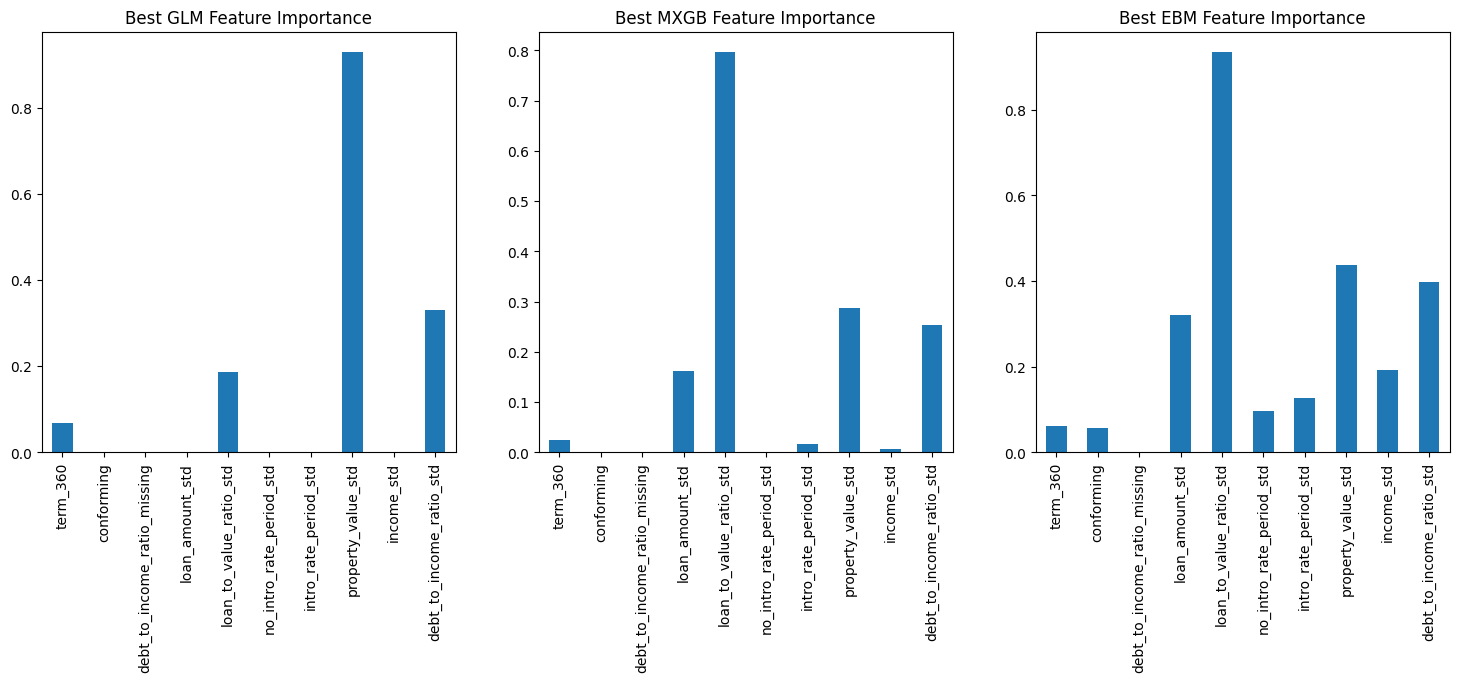

In [79]:
# init 3-pane plot
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2.2, wspace=0.2)

# plot global FI across three panes
_ = global_fi['GLM Importance'].plot(kind='bar', ax=ax0, title='Best GLM Feature Importance')
_ = global_fi['MXGB Importance'].plot(kind='bar', ax=ax1, title='Best MXGB Feature Importance')
_ = global_fi['EBM Importance'].plot(kind='bar', ax=ax2, title='Best EBM Feature Importance')

#### Compare local feature importance across models

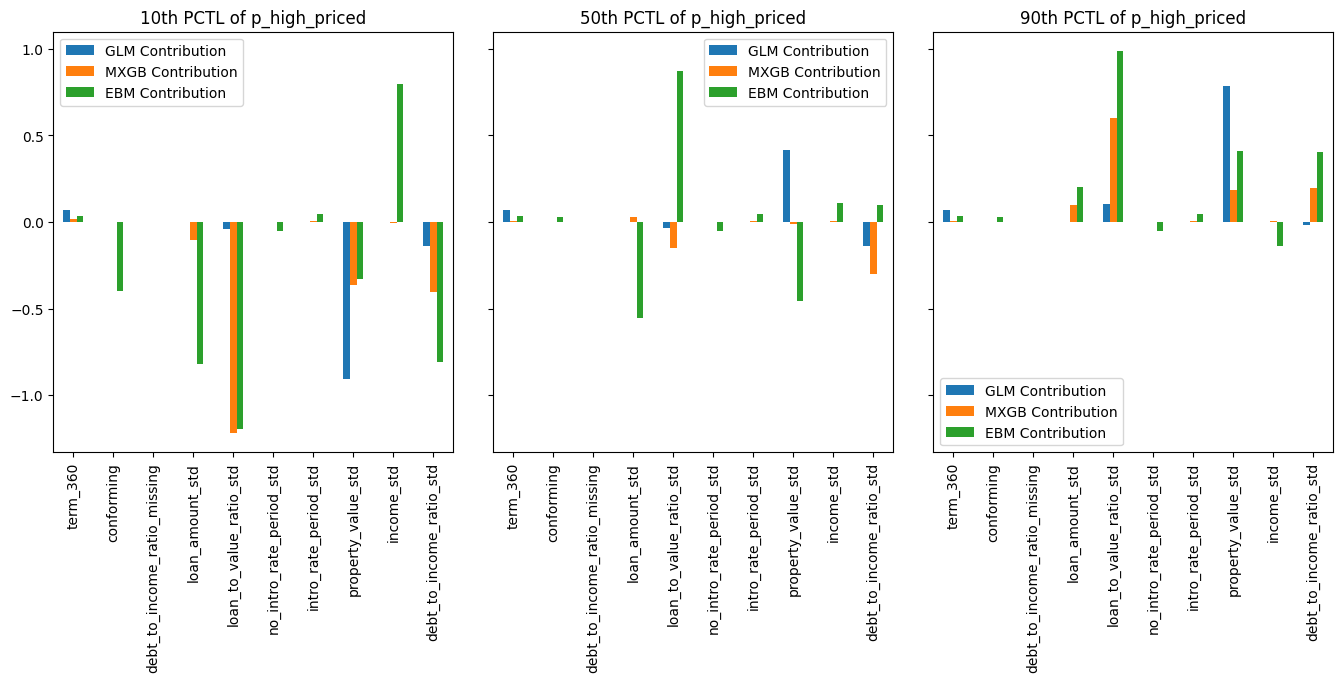

In [80]:
## init 3-pane plot
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2, wspace=0.1)

# plot comparisons of local FI across 3 panes
_ = local_fi_dict[10].plot(kind='bar', ax=ax0,
                             title='10th PCTL of p_high_priced')

_ = local_fi_dict[50].plot(kind='bar', ax=ax1,
                             title='50th PCTL of p_high_priced')

_ = local_fi_dict[90].plot(kind='bar', ax=ax2,
                             title='90th PCTL of p_high_priced')


#### Utility function for partial dependence

In [81]:
def par_dep(x_name, valid, model, model_type, resolution=20, bins=None):

    """ Creates Pandas DataFrame containing partial dependence or ICE
        for a single input variable.
        :param x_name: Variable for which to calculate partial dependence.
        :param valid: Pandas validation frame.
        :param model: Trained model object (assumes binary classifier).
        :param model_type: Kind of model: h2o, xgb, or ebm.
        :param resolution: The number of points across the domain of xs for which
                           to calculate partial dependence, default 20.
        :param bins: List of values at which to set xs, default 20 equally-spaced
                     points between column minimum and maximum.
        :return: Pandas DataFrame containing partial dependence values.
    """

    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None

    # determine values at which to calculate partial dependence
    if bins is None:
        min_ = valid[x_name].min()
        max_ = valid[x_name].max()
        by = (max_ - min_) / resolution
        # modify max and by
        # to preserve resolution and actually search up to max
        bins = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))

    # cache original column values
    col_cache = valid.loc[:, x_name].copy(deep=True)

    # calculate partial dependence
    # by setting column of interest to constant
    # and scoring the altered data and taking the mean of the predictions
    temp_df = valid.copy(deep=True)
    temp_df.loc[:, x_name] = bins[0]
    for j, _ in enumerate(bins):
        if j + 1 < len(bins):
            valid.loc[:, x_name] = bins[j + 1]
            temp_df = pd.concat([temp_df, valid], axis=0)

    temp_df.reset_index(inplace=True, drop=True) # or else dumb pandas indexes cause all rows to have same partial dependence

    # return input frame to original cached state
    valid.loc[:, x_name] = col_cache

    # model predictions
    # probably assumes binary classification
    if model_type == 'h2o':
        temp_df['partial_dependence'] = model.predict(h2o.H2OFrame(temp_df))['p1'].as_data_frame()
    if model_type == 'xgb':
        temp_df['partial_dependence'] = pd.DataFrame(model.predict(xgb.DMatrix(temp_df), iteration_range=(0, best_mxgb.best_iteration)), columns=['phat'])
    if model_type == 'ebm':
        temp_df['partial_dependence'] = pd.DataFrame(model.predict_proba(temp_df)[:, 1], columns=['phat'])

    return pd.DataFrame(temp_df[[x_name, 'partial_dependence']].groupby([x_name]).mean()).reset_index()

#### Calculate partial dependence for all X and models

In [82]:
# start local timer
pd_tic = time.time()

# init dict to hold results
pd_dict = {}

# cycle through names and model types to calculate par dep
for name in x_names:

    print('Calculating partial dependence for %s ...' % name)

    # setup a dataframe to hold results
    # use bins from first par_dep() run
    pd_dict[name] = pd.DataFrame(columns=[name, 'h2o', 'xgb', 'ebm'])
    first_pd = par_dep(name, valid[x_names], best_glm, 'h2o')
    pd_dict[name][name] = first_pd[name]
    bins = first_pd[name]
    pd_dict[name]['h2o'] = first_pd['partial_dependence']

    # calculate par dep for remaining models
    pd_dict[name]['xgb'] = par_dep(name, valid[x_names], best_mxgb, 'xgb', bins=bins)['partial_dependence']
    pd_dict[name]['ebm'] = par_dep(name, valid[x_names], best_ebm, 'ebm', bins=bins)['partial_dependence']

print('Done.')

# end local timer
pd_toc = time.time() - pd_tic
print('Partial dependence calculated in %.2f s.' % (pd_toc))

Calculating partial dependence for term_360 ...


<ipython-input-81-15b1f9c8ad12>:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.053000000000000005' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  valid.loc[:, x_name] = bins[j + 1]
/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
<ipython-input-81-15b1f9c8ad12>:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.053000000000000005' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  valid.loc[:, x_name] = bins[j + 1]
<ipytho

Calculating partial dependence for conforming ...


<ipython-input-81-15b1f9c8ad12>:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.053000000000000005' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  valid.loc[:, x_name] = bins[j + 1]
/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
<ipython-input-81-15b1f9c8ad12>:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.053000000000000005' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  valid.loc[:, x_name] = bins[j + 1]
<ipytho

Calculating partial dependence for debt_to_income_ratio_missing ...


<ipython-input-81-15b1f9c8ad12>:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.053000000000000005' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  valid.loc[:, x_name] = bins[j + 1]
/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
<ipython-input-81-15b1f9c8ad12>:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.053000000000000005' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  valid.loc[:, x_name] = bins[j + 1]
<ipytho

Calculating partial dependence for loan_amount_std ...


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Calculating partial dependence for loan_to_value_ratio_std ...


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Calculating partial dependence for no_intro_rate_period_std ...


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Calculating partial dependence for intro_rate_period_std ...


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Calculating partial dependence for property_value_std ...


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Calculating partial dependence for income_std ...


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Calculating partial dependence for debt_to_income_ratio_std ...


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Done.
Partial dependence calculated in 249.78 s.


#### Plot partial dependence for all features and models

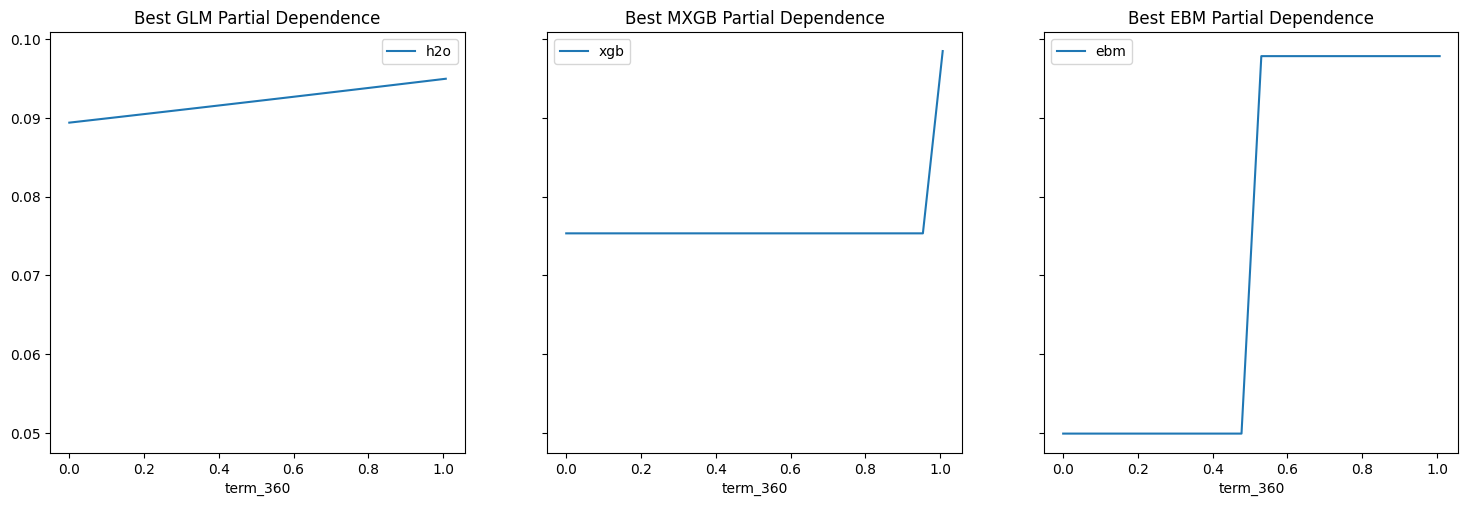

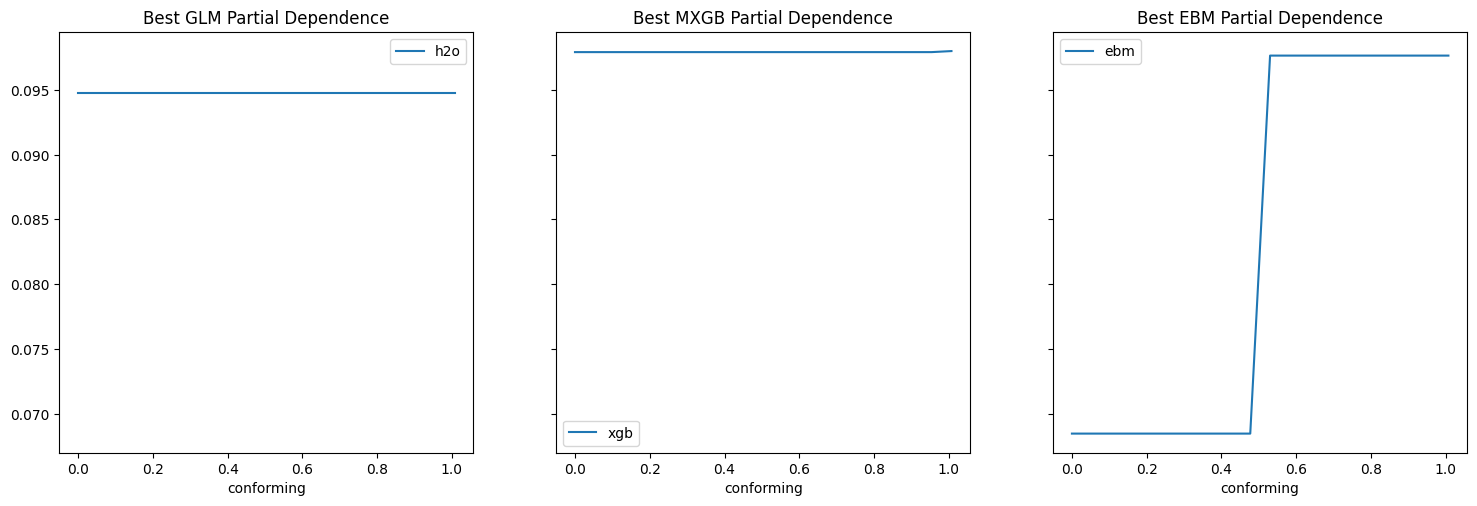

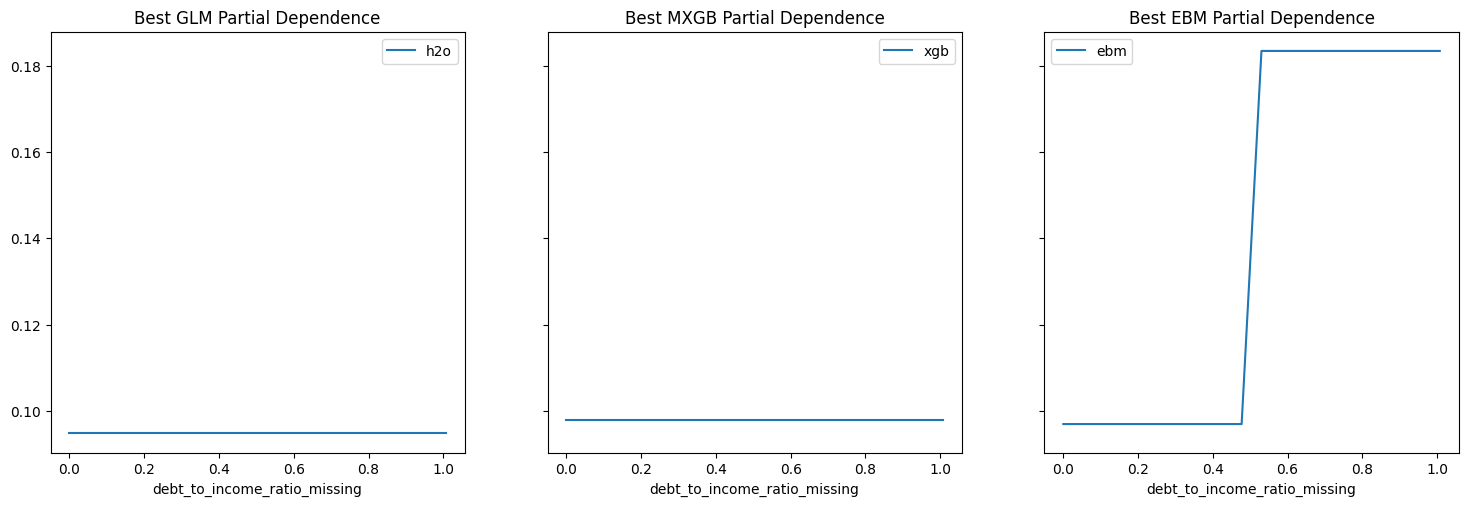

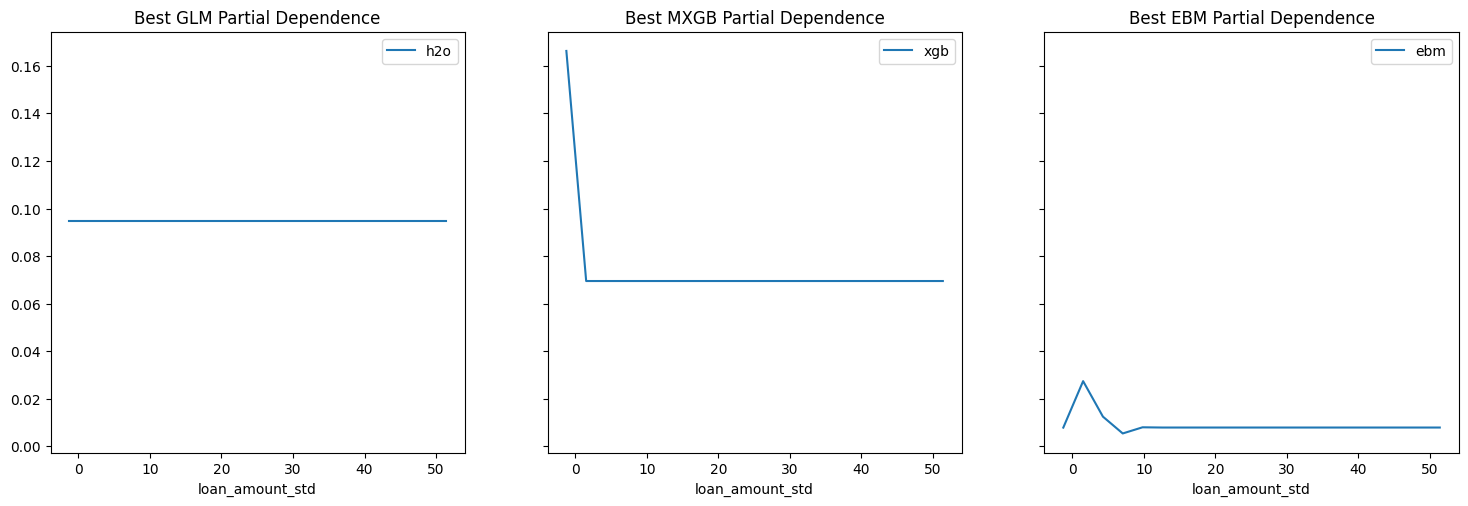

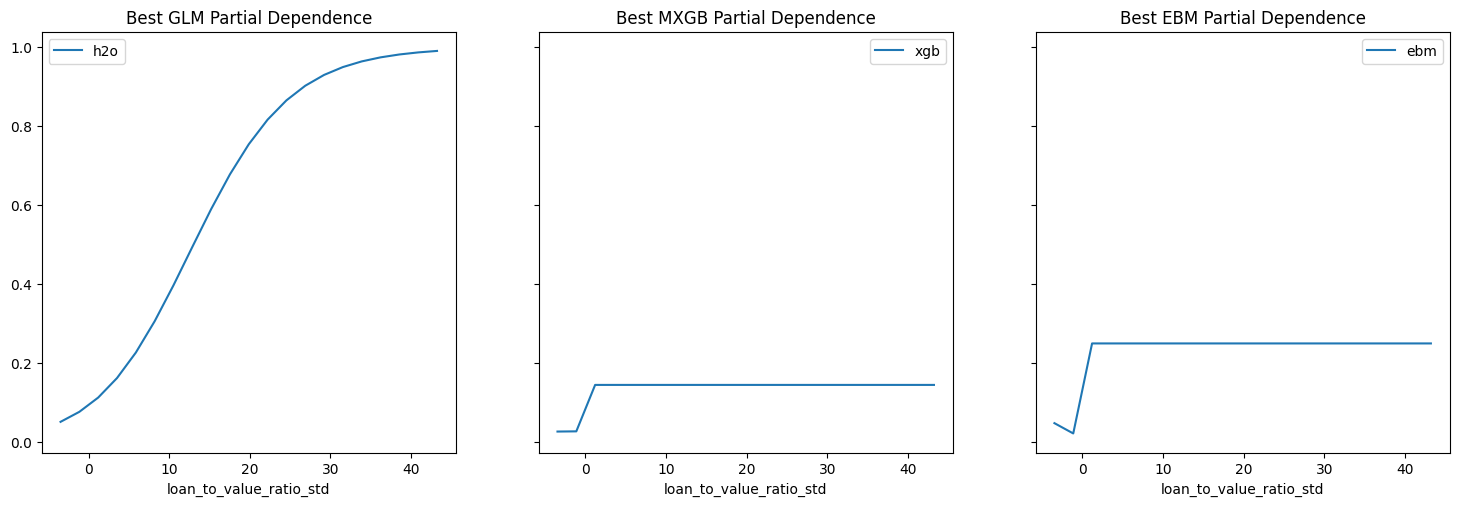

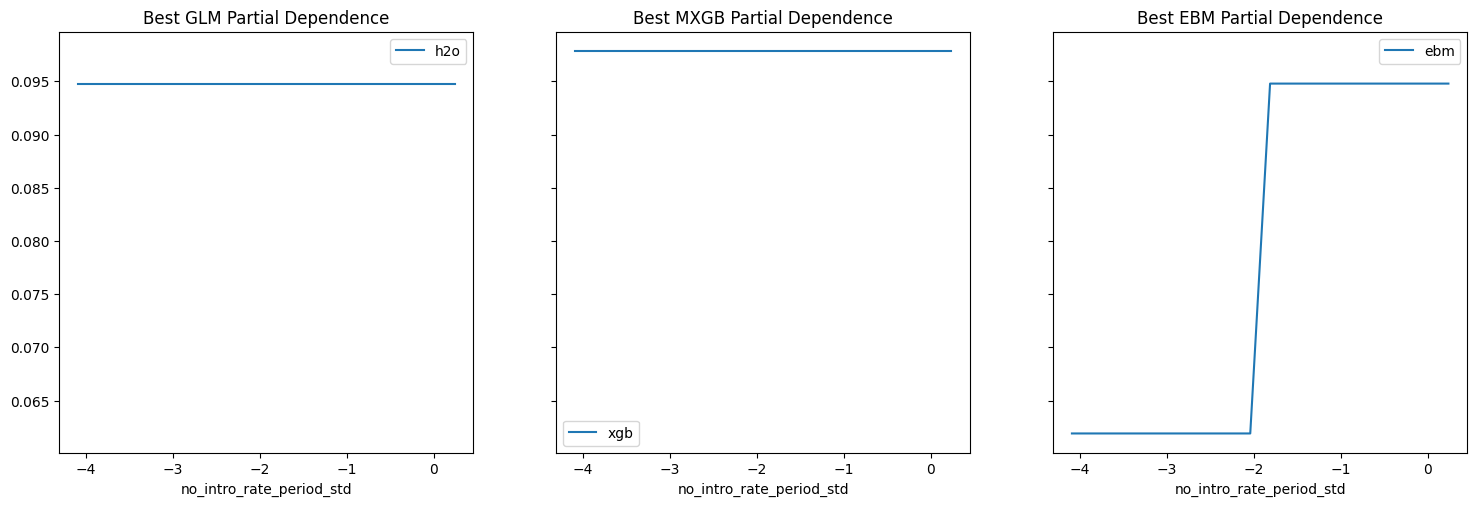

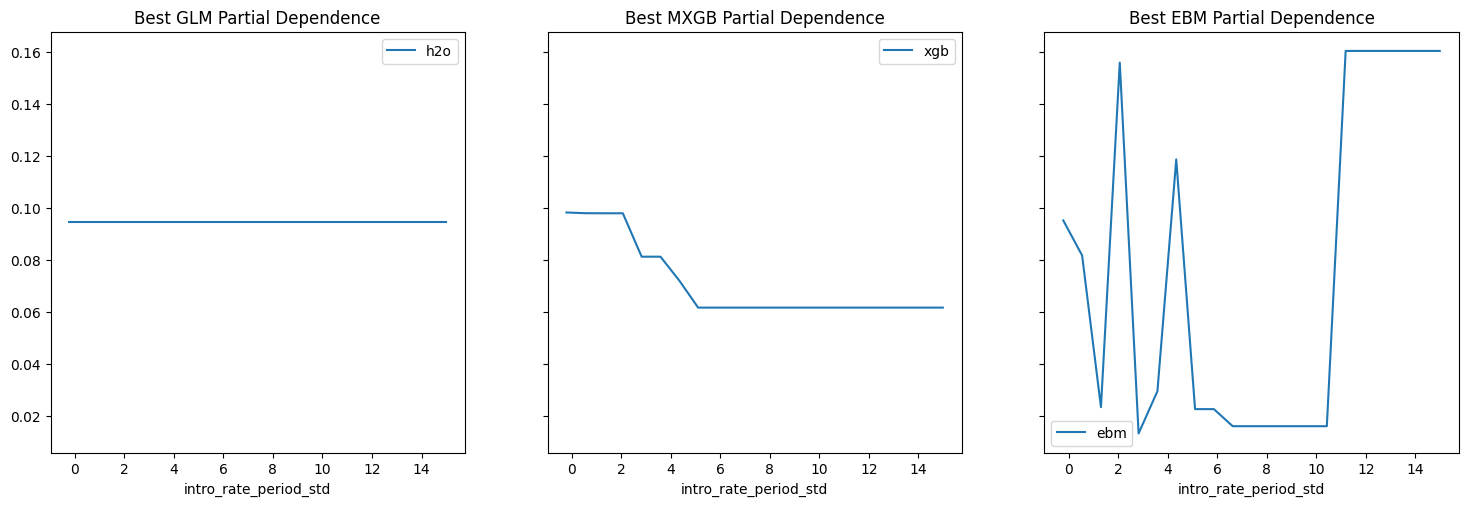

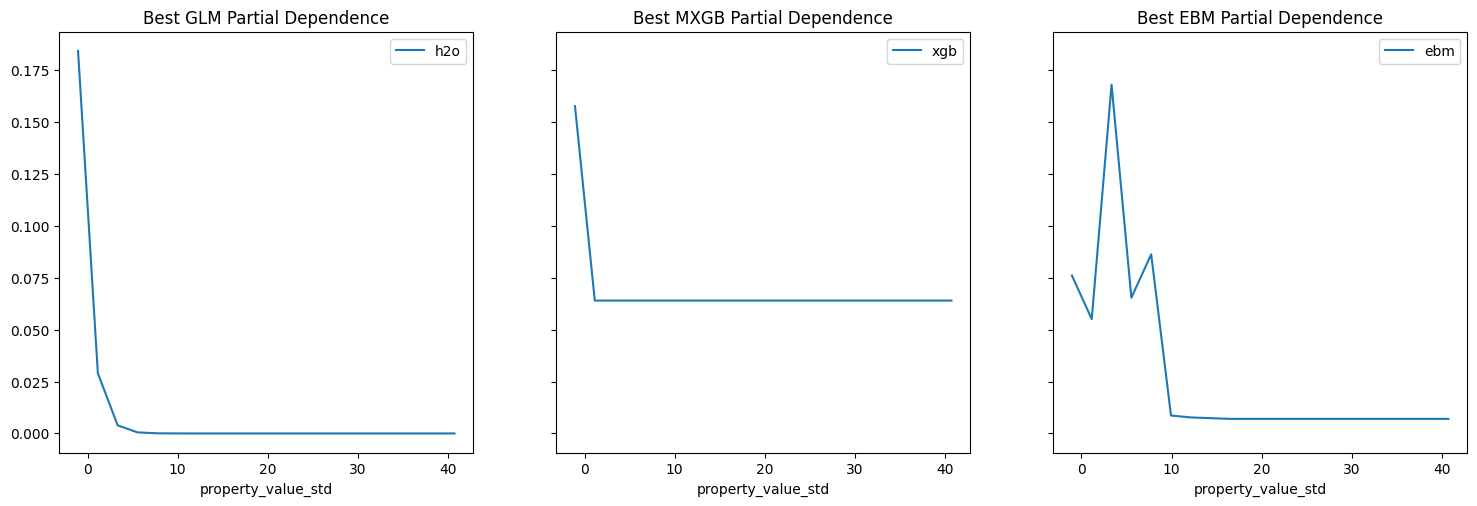

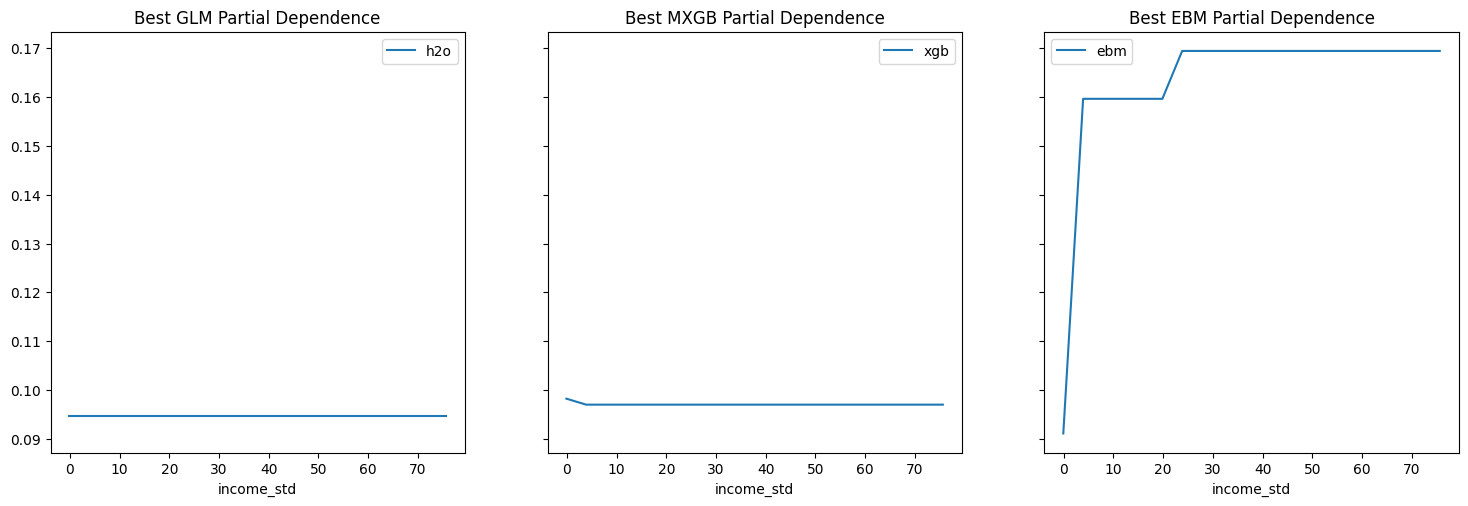

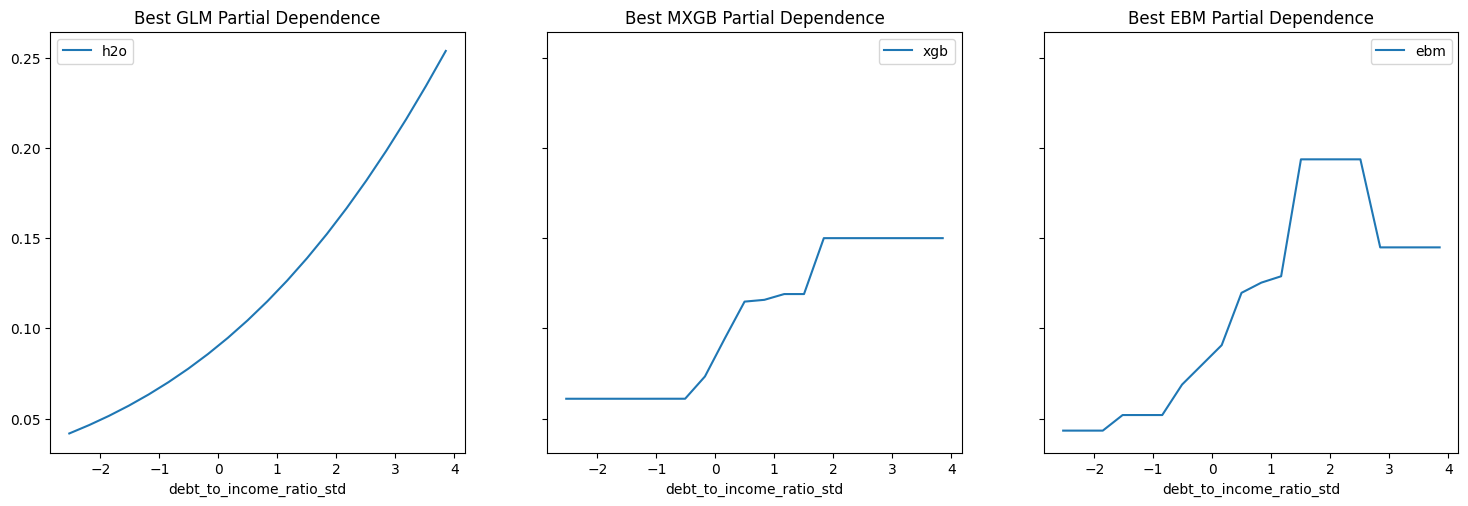

In [83]:
# loop through names to calculate par dep
for name in x_names:

    # init 3-pane plot
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True)
    plt.tight_layout()
    plt.subplots_adjust(left=0, right=2.2, wspace=0.2)

    # plot par dep from each model across frames
    pd_dict[name].plot(kind='line', x=name, y='h2o', ax=ax0, title='Best GLM Partial Dependence')
    ax0.set_xlabel(name)
    pd_dict[name].plot(kind='line', x=name, y='xgb', ax=ax1, title='Best MXGB Partial Dependence')
    ax1.set_xlabel(name)
    pd_dict[name].plot(kind='line', x=name, y='ebm', ax=ax2, title='Best EBM Partial Dependence')
    ax2.set_xlabel(name)


Three-Pane Feature Importance Comparison- referred to ChatGPT

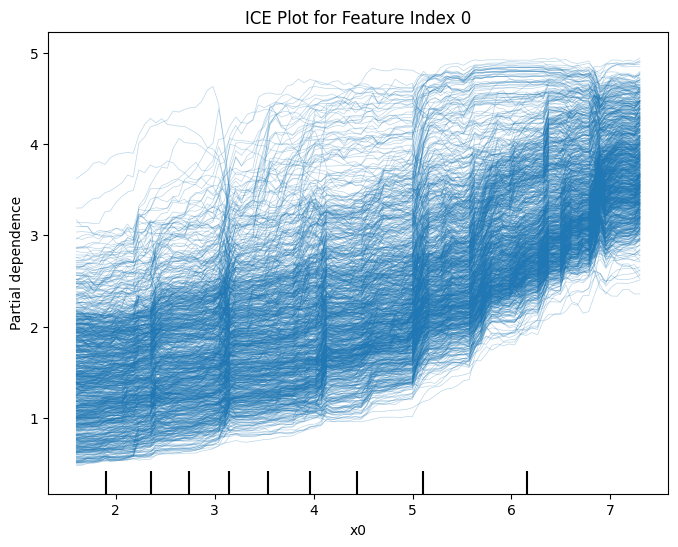

In [84]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Assume 'model' is your trained model and 'X' is your data (e.g., your training or testing set)
# Specify the feature index for which you want to generate the ICE plot. Here, we use index 0 as an example.
feature_index = 0

# Create the ICE plot. The "kind='individual'" parameter plots the ICE curves for each sample.
fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(
    model, X, features=[feature_index], kind='individual', ax=ax
)
ax.set_title('ICE Plot for Feature Index 0')
ax.set_xlabel('Feature Value')
ax.set_ylabel('Predicted Response')
plt.show()


#### End timer

In [86]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 645.62 s.


#### Shutdown h2o

In [ ]:
h2o.cluster().shutdown(prompt=False)

H2O session _sid_a83f closed.
